In [276]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# from keras.layers import Input, Dense
# from keras.models import Model, Sequential
# from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("./creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

Num GPUs Available:  1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. Let's look at the distribution of target. 

In [2]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Count,count,percent
0,0,284315,0.0
1,1,492,0.0


In [3]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [4]:
col_names = ['Amount']
data = Standard_Scaler (data, col_names)

In [5]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,23.996111,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,23.996389,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,23.996667,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,23.996667,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


In [6]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [7]:
ttx = data.drop(["Class"], axis=1)
tty = data["Class"]
train_x, val_x, train_y, val_y = train_test_split(ttx, tty, test_size=0.25, stratify=tty, random_state=7)

In [283]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.59      0.72       123

    accuracy                           1.00     71202
   macro avg       0.95      0.80      0.86     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9991854161399961

AUC: 0.9829


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [284]:

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, random_state=7).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.75      0.84       123

    accuracy                           1.00     71202
   macro avg       0.98      0.87      0.92     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.999522485323446

AUC: 0.9456


In [285]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.92      0.74      0.82       123

    accuracy                           1.00     71202
   macro avg       0.96      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9994382180275835

AUC: 0.9226


In [278]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(train_x, train_y)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = best_model.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.95      0.74      0.83       123

    accuracy                           1.00     71202
   macro avg       0.97      0.87      0.92     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9860


In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
trai_x, trai_y = smt.fit_resample(train_x, train_y)

In [286]:
clf = LogisticRegression(solver="lbfgs").fit(trai_x, trai_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.06      0.92      0.11       123

    accuracy                           0.97     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.97      0.99     71202


Accuracy Score:  0.9738630937333221

AUC: 0.9858


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [287]:

clf = RandomForestClassifier(n_jobs=-1, random_state=7).fit(trai_x, trai_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.89      0.82      0.85       123

    accuracy                           1.00     71202
   macro avg       0.94      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9995084407741356

AUC: 0.9736


In [288]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(trai_x, trai_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.39      0.85      0.54       123

    accuracy                           1.00     71202
   macro avg       0.70      0.92      0.77     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9974860256734361

AUC: 0.9302


In [279]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(trai_x, trai_y)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = best_model.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.78      0.85      0.81       123

    accuracy                           1.00     71202
   macro avg       0.89      0.93      0.91     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9897


In [292]:
from imblearn.over_sampling import BorderlineSMOTE
smt = BorderlineSMOTE()
trai_x_bsmote, trai_y_bsmote = smt.fit_resample(train_x, train_y)

In [293]:
clf = LogisticRegression(solver="lbfgs").fit(trai_x_bsmote, trai_y_bsmote)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.13      0.86      0.23       123

    accuracy                           0.99     71202
   macro avg       0.57      0.93      0.61     71202
weighted avg       1.00      0.99      0.99     71202


Accuracy Score:  0.989958147243055

AUC: 0.9468


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [294]:
clf = RandomForestClassifier(n_jobs=-1, random_state=7).fit(trai_x_bsmote, trai_y_bsmote)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.92      0.79      0.85       123

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.999522485323446

AUC: 0.9575


In [295]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(trai_x_bsmote, trai_y_bsmote)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.70      0.82      0.75       123

    accuracy                           1.00     71202
   macro avg       0.85      0.91      0.88     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9990730597455127

AUC: 0.9265


In [296]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(trai_x_bsmote, trai_y_bsmote)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = best_model.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.84      0.84      0.84       123

    accuracy                           1.00     71202
   macro avg       0.92      0.92      0.92     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9873


In [297]:
from imblearn.over_sampling import RandomOverSampler
smt = RandomOverSampler()
trai_x_ros, trai_y_ros = smt.fit_resample(train_x, train_y)

In [298]:
clf = LogisticRegression(solver="lbfgs").fit(trai_x_ros, trai_y_ros)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.06      0.93      0.12       123

    accuracy                           0.98     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.98      0.99     71202


Accuracy Score:  0.976377068059886

AUC: 0.9864


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [299]:
clf = RandomForestClassifier(n_jobs=-1, random_state=7).fit(trai_x_ros, trai_y_ros)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.96      0.79      0.87       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9995786635206876

AUC: 0.9701


In [300]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(trai_x_ros, trai_y_ros)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.60      0.80      0.69       123

    accuracy                           1.00     71202
   macro avg       0.80      0.90      0.84     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9987359905620629

AUC: 0.9225


In [301]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(trai_x_ros, trai_y_ros)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = best_model.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.89      0.82      0.86       123

    accuracy                           1.00     71202
   macro avg       0.95      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9821


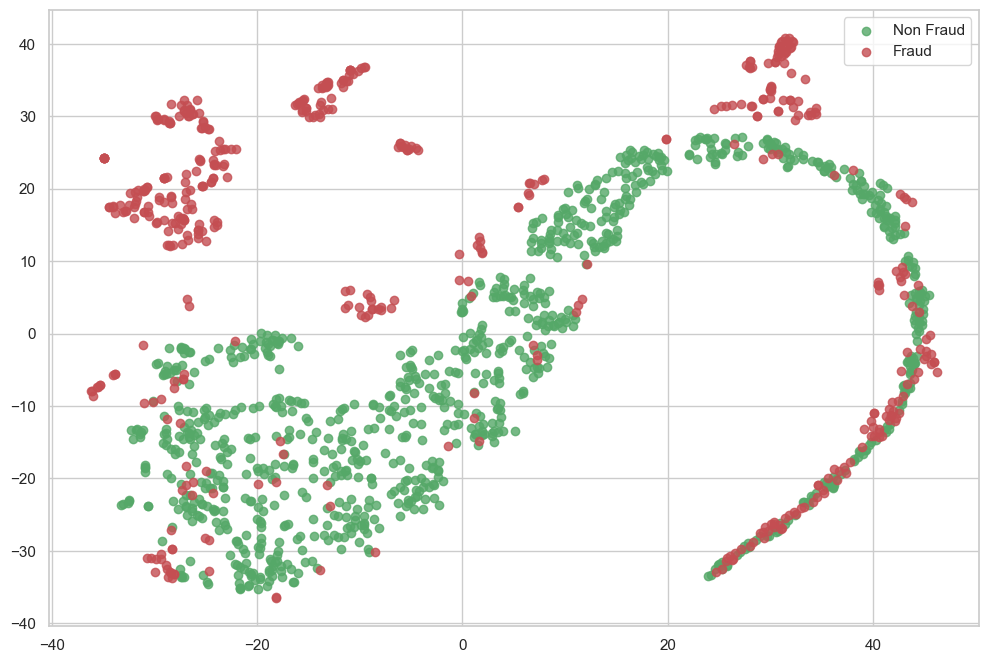

In [4]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    # plt.scatter(X_t[y1 == 0, 0], X_t[y1 == 0, 1], c=cmap(normalize(X_train_kcm["Class"][X_train_kcm["Class"] == 0])), s=10, marker='o', label='Majority Class')
    # plt.scatter(X_t[y1 == 1, 0], X_t[y1 == 1, 1], c=cmap(normalize(X_train_kcm["Class"][X_train_kcm["Class"] == 1])), s=50, marker='^', edgecolors='black', linewidths=1, label='Minority Class')
    plt.legend(loc='best')
    # plt.savefig(name)
    plt.show()
    
tsne_plot(X, Y)

In [201]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.

In [202]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Before training, let's perform min max scaling. 

In [216]:
x_norm, x_fraud = train_x[train_y==0], train_x[train_y==1]

In [144]:
x_norm.shape

(213236, 30)

In [217]:
autoencoder.fit(x_norm[0:50000], x_norm[0:50000], 
                batch_size = 256, epochs = 120, 
                shuffle = True, validation_split = 0.20)

Epoch 1/120
157/157 [==============================] - 2s 9ms/step - loss: 9.2298 - val_loss: 9.2823
Epoch 2/120
157/157 [==============================] - 1s 6ms/step - loss: 9.2186 - val_loss: 9.2710
Epoch 3/120
157/157 [==============================] - 1s 6ms/step - loss: 9.2062 - val_loss: 9.2556
Epoch 4/120
157/157 [==============================] - 1s 6ms/step - loss: 9.0033 - val_loss: 8.4137
Epoch 5/120
157/157 [==============================] - 1s 6ms/step - loss: 7.5194 - val_loss: 6.7856
Epoch 6/120
157/157 [==============================] - 1s 6ms/step - loss: 6.0680 - val_loss: 5.4926
Epoch 7/120
157/157 [==============================] - 1s 7ms/step - loss: 4.9164 - val_loss: 4.4795
Epoch 8/120
157/157 [==============================] - 1s 6ms/step - loss: 4.0317 - val_loss: 3.7169
Epoch 9/120
157/157 [==============================] - 1s 7ms/step - loss: 3.3762 - val_loss: 3.1597
Epoch 10/120
157/157 [==============================] - 1s 6ms/step - loss: 2.9010 - val_lo

In [218]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

In [219]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [220]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

# tsne_plot(rep_x, rep_y, "latent_representation.png")

In [221]:
zero_columns = np.all(rep_x == 0, axis=0)
print(zero_columns)
# Drop these columns
# rep_x_cleaned = rep_x[:, ~zero_columns]

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


In [222]:
rep_x_df = pd.DataFrame(rep_x)

In [223]:
rep_x_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,0.424701,0.042896,1.539475,0.689085,0.263727,1.156598,0.968784,0.011556,0.098660,0.094106,...,1.274631,0.409608,2.414097,0.669918,0.041329,0.024794,0.044331,0.902995,0.011900,1.646097
std,0.253723,0.128808,0.670671,0.469721,0.236101,0.428333,0.399911,0.081461,0.256736,0.246688,...,0.515070,0.343970,0.675718,0.417517,0.155408,0.103756,0.163895,0.391827,0.084835,0.574136
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251211,0.000000,1.191536,0.341563,0.054964,0.925535,0.742012,0.000000,0.000000,0.000000,...,0.968520,0.076857,2.267391,0.370291,0.000000,0.000000,0.000000,0.692141,0.000000,1.387887
50%,0.404687,0.000000,1.688134,0.637080,0.226687,1.236782,1.010101,0.000000,0.000000,0.000000,...,1.359496,0.404590,2.591921,0.670225,0.000000,0.000000,0.000000,0.937086,0.000000,1.785146
75%,0.580195,0.000000,2.056984,0.977760,0.404255,1.465821,1.223165,0.000000,0.016819,0.008292,...,1.665145,0.644318,2.810107,0.946304,0.000000,0.000000,0.000000,1.174433,0.000000,2.056479
max,1.930993,1.891318,2.947512,2.942363,2.130038,3.000133,3.007452,1.595154,2.082739,2.268358,...,2.583326,3.948809,3.987258,3.039770,2.597023,2.152476,2.765144,2.498524,1.635432,3.108173


In [224]:
rep_y_df = pd.DataFrame(rep_y)

In [225]:
rep_y_df

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
213600,1.0
213601,1.0
213602,1.0
213603,1.0


In [226]:
rep_df = rep_x_df.copy()
rep_df[50] = rep_y_df

In [227]:
rep_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,0.424701,0.042896,1.539475,0.689085,0.263727,1.156598,0.968784,0.011556,0.098660,0.094106,...,0.409608,2.414097,0.669918,0.041329,0.024794,0.044331,0.902995,0.011900,1.646097,0.001727
std,0.253723,0.128808,0.670671,0.469721,0.236101,0.428333,0.399911,0.081461,0.256736,0.246688,...,0.343970,0.675718,0.417517,0.155408,0.103756,0.163895,0.391827,0.084835,0.574136,0.041527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251211,0.000000,1.191536,0.341563,0.054964,0.925535,0.742012,0.000000,0.000000,0.000000,...,0.076857,2.267391,0.370291,0.000000,0.000000,0.000000,0.692141,0.000000,1.387887,0.000000
50%,0.404687,0.000000,1.688134,0.637080,0.226687,1.236782,1.010101,0.000000,0.000000,0.000000,...,0.404590,2.591921,0.670225,0.000000,0.000000,0.000000,0.937086,0.000000,1.785146,0.000000
75%,0.580195,0.000000,2.056984,0.977760,0.404255,1.465821,1.223165,0.000000,0.016819,0.008292,...,0.644318,2.810107,0.946304,0.000000,0.000000,0.000000,1.174433,0.000000,2.056479,0.000000
max,1.930993,1.891318,2.947512,2.942363,2.130038,3.000133,3.007452,1.595154,2.082739,2.268358,...,3.948809,3.987258,3.039770,2.597023,2.152476,2.765144,2.498524,1.635432,3.108173,1.000000


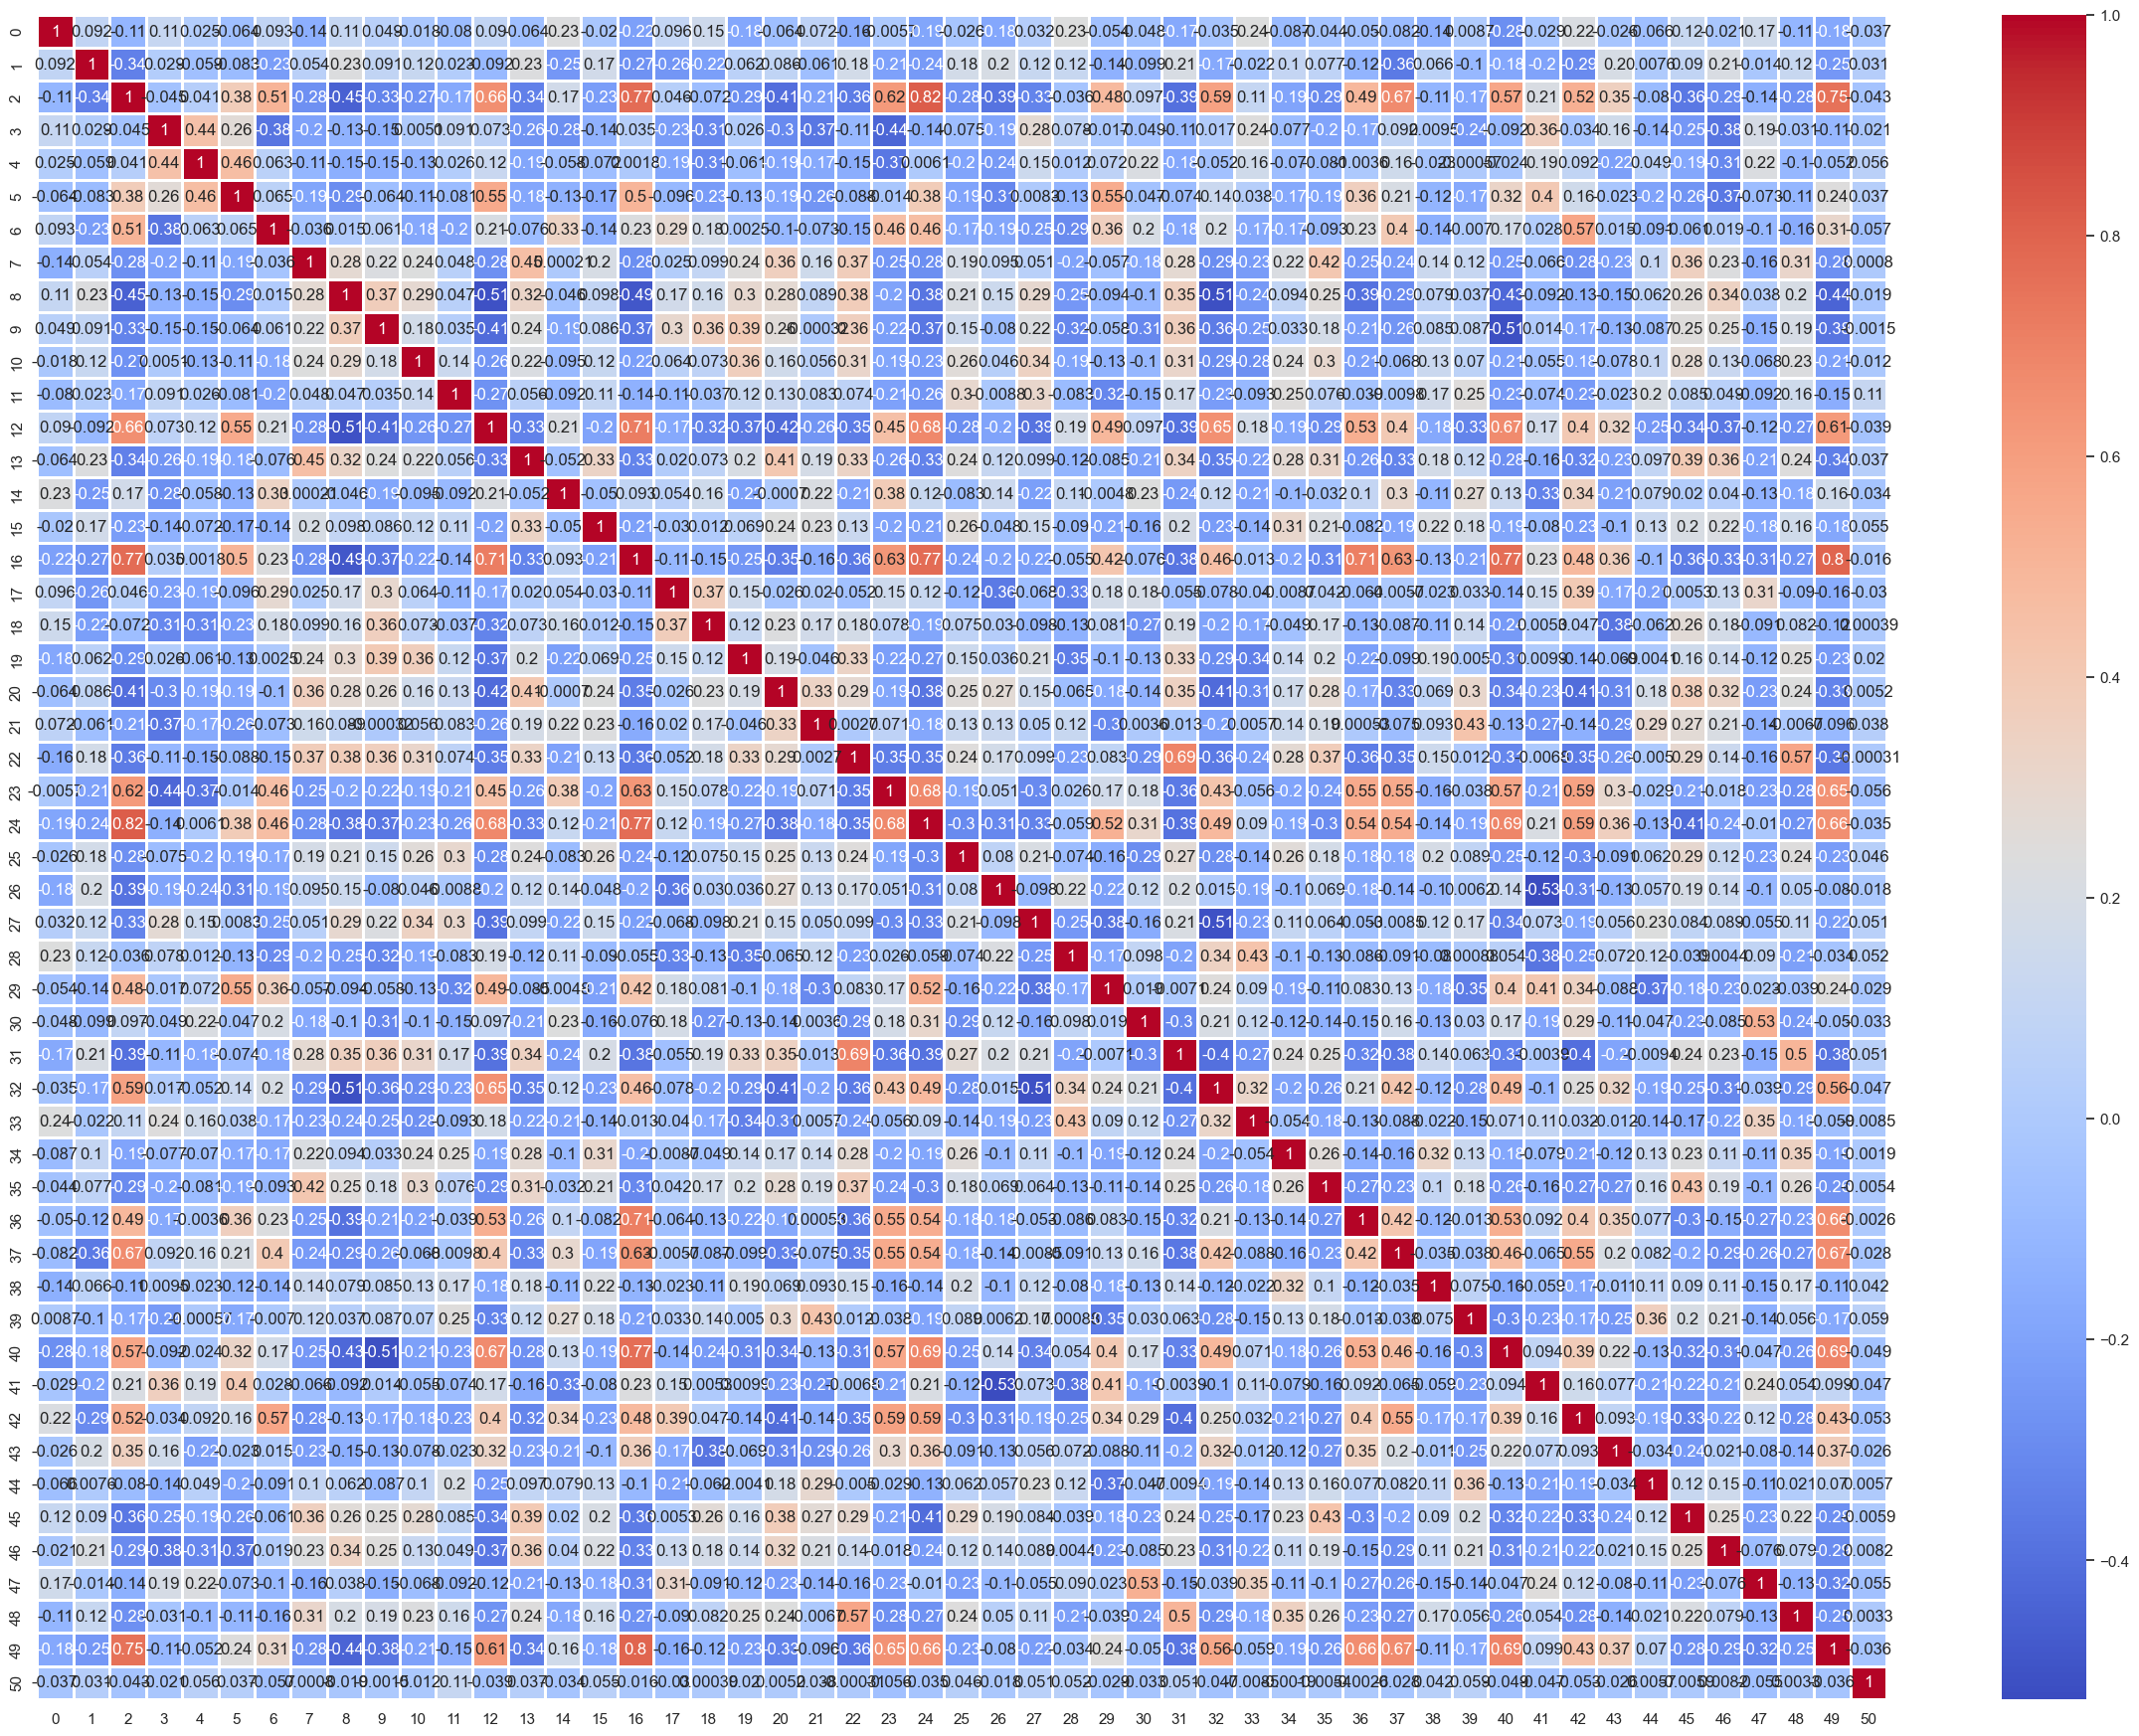

In [228]:
correlation_matrix = rep_df.corr(method="spearman")
target_correlation = correlation_matrix[50].sort_values(ascending=False)
plt.figure(figsize=(30, 22))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=2)
plt.show()

In [229]:
important_features = []
non_important_features = []
class_corr_abs = list(abs(target_correlation).items())
print(len(class_corr_abs))
print(class_corr_abs)
class_corr_abs.sort(key = lambda x: x[1])
class_corr_abs.reverse()
print(class_corr_abs)
important_features = class_corr_abs[:20]
non_important_features = class_corr_abs[20:]

print([x[0] for x in important_features ])
print(important_features)

51
[(50, 1.0), (11, 0.11350629147505457), (39, 0.05932627987452926), (4, 0.05630569280358603), (15, 0.054506110473984605), (28, 0.051925153843129), (31, 0.051445921756568085), (27, 0.05118605880885879), (25, 0.045694147389534076), (38, 0.04202910528789077), (21, 0.038076758740068314), (13, 0.036765182535120615), (5, 0.03657525220452478), (1, 0.03135550889911529), (19, 0.020402818614323765), (46, 0.008249855004868632), (44, 0.005711502193936995), (20, 0.005165084160892554), (48, 0.0033174957756058414), (7, 0.0008048572056544839), (18, 0.0003876805158169198), (22, 0.00031188952820711957), (9, 0.0015257097794245103), (34, 0.001898734140378304), (36, 0.0026054065975657523), (35, 0.005390772773053591), (45, 0.00591539185171117), (33, 0.008507105999847404), (10, 0.012137757628352747), (16, 0.015751144533354217), (26, 0.01770406825850506), (8, 0.01942779830649067), (3, 0.020635094432262885), (43, 0.026492409254135308), (37, 0.027578369083116776), (29, 0.029118583892269585), (17, 0.03032108404

In [230]:
important_features.pop(0)
important_features

[(11, 0.11350629147505457),
 (39, 0.05932627987452926),
 (6, 0.05690777611997028),
 (4, 0.05630569280358603),
 (23, 0.05606655861882032),
 (47, 0.05534754729403509),
 (15, 0.054506110473984605),
 (42, 0.052848868015617584),
 (28, 0.051925153843129),
 (31, 0.051445921756568085),
 (27, 0.05118605880885879),
 (40, 0.04854075422609499),
 (41, 0.04734329908033718),
 (32, 0.046762265797659096),
 (25, 0.045694147389534076),
 (2, 0.04279574406307049),
 (38, 0.04202910528789077),
 (12, 0.03929575776148572),
 (21, 0.038076758740068314)]

In [231]:
rep_df[[x[0] for x in important_features ]].describe()

,11,39,6,4,23,47,15,42,28,31,27,40,41,32,25,2,38,12,21
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,0.014030,0.038929,0.968784,0.263727,1.550428,0.902995,0.007617,2.414097,0.531300,0.026719,0.104373,1.274631,0.409608,2.571062,0.013607,1.539475,0.004899,1.917874,0.033289
std,0.084107,0.172521,0.399911,0.236101,0.614698,0.391827,0.068634,0.675718,0.305270,0.123527,0.236209,0.515070,0.343970,0.772145,0.092047,0.670671,0.043254,0.731983,0.139799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.742012,0.054964,1.164008,0.692141,0.000000,2.267391,0.337206,0.000000,0.000000,0.968520,0.076857,2.482518,0.000000,1.191536,0.000000,1.573516,0.000000
50%,0.000000,0.000000,1.010101,0.226687,1.622527,0.937086,0.000000,2.591921,0.534308,0.000000,0.000000,1.359496,0.404590,2.822182,0.000000,1.688134,0.000000,2.097714,0.000000
75%,0.000000,0.000000,1.223165,0.404255,1.997401,1.174433,0.000000,2.810107,0.704433,0.000000,0.072320,1.665145,0.644318,3.008516,0.000000,2.056984,0.000000,2.443707,0.000000
max,2.212158,2.939327,3.007452,2.130038,3.707966,2.498524,2.463707,3.987258,2.582161,2.419681,3.138391,2.583326,3.948809,4.046519,2.037468,2.947512,1.322972,3.885806,2.600234


In [232]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=40, init='k-means++', random_state=42).fit(rep_df[[x[0] for x in important_features ]])

c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [233]:
# rep_df[50] = rep_y_df
rep_df['cluster'] = kmeans.labels_


In [234]:
class_counts = rep_df.groupby(['cluster', 50]).size().unstack(fill_value=0).reset_index().sort_values(by=1, ascending=False)
class_counts.head(50)

50,cluster,0.0,1.0
34,34,4219,95
8,8,989,76
11,11,2147,52
13,13,4461,44
29,29,4668,19
27,27,4005,15
4,4,7116,13
32,32,11363,7
2,2,700,5
14,14,2025,4


## COOKING

In [235]:
x_norm["Class"] = 0
x_fraud["Class"] = 1
x_normal_fraud = pd.concat([x_norm, x_fraud], axis=0)
x_normal_fraud['cluster'] = kmeans.labels_

C:\Users\moham\AppData\Local\Temp\ipykernel_1788\1900664036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_norm["Class"] = 0
C:\Users\moham\AppData\Local\Temp\ipykernel_1788\1900664036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_fraud["Class"] = 1


In [236]:
x_normal_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,cluster
196856,12.590556,2.157073,0.011847,-2.585172,-0.359370,1.119840,-0.601333,0.606321,-0.295127,0.071329,...,0.428273,-0.122308,-0.105153,0.525711,0.242608,-0.099789,-0.091576,-0.330120,0,38
280774,23.150556,2.043872,0.986768,-2.041725,3.613265,1.572191,-0.520737,1.157213,-0.478013,-1.809912,...,0.874685,-0.143166,0.719673,0.755891,0.331817,-0.100773,-0.071706,-0.350191,0,4
73325,15.301111,-2.491684,1.334972,-0.095626,-1.645557,-0.317902,-0.441877,1.033645,-0.705012,1.433620,...,0.085392,0.314210,-0.396547,-1.190353,0.384048,-1.609700,-0.035813,0.022871,0,37
66691,14.491944,-1.110222,-1.721628,1.746256,0.107119,0.534344,-0.452864,-0.883476,0.134388,2.074968,...,0.730807,0.026276,-0.424837,0.035723,-0.228075,0.021928,-0.037238,-0.029384,0,28
50465,12.361667,0.855743,-1.161616,1.377096,0.525844,-1.346440,1.239605,-1.183613,0.571644,1.703339,...,0.138745,-0.148614,-0.189599,0.139455,1.130242,-0.010222,0.020406,0.166522,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147548,0.631111,-3.859881,2.632881,-5.264265,3.446113,-0.675231,-1.904959,-3.291041,-0.985766,-1.168114,...,0.785075,0.068412,0.778961,-0.863166,-0.006810,-1.065734,1.773326,-0.348512,1,34
43773,11.568333,-3.240187,2.978122,-4.162314,3.869124,-3.645256,-0.126271,-4.744730,-0.065331,-2.168366,...,0.231910,-0.036490,0.042640,-0.438330,-0.125821,0.421300,0.003146,0.335721,1,34
12070,5.814167,-16.367923,9.223692,-23.270631,11.844777,-9.462037,-2.450444,-16.925152,1.384208,-6.287736,...,1.004602,1.188212,-1.047184,-0.035573,0.664900,2.122796,-1.416741,-0.349231,1,8
279863,22.983889,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1.206024,1,27


In [237]:
class_counts = x_normal_fraud.groupby(['cluster', 'Class']).size().unstack(fill_value=0).reset_index().sort_values(by=1, ascending=False)
class_counts.head(50)

Class,cluster,0,1
34,34,4219,95
8,8,989,76
11,11,2147,52
13,13,4461,44
29,29,4668,19
27,27,4005,15
4,4,7116,13
32,32,11363,7
2,2,700,5
14,14,2025,4


In [238]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

# Function to build VAE model
def build_vae(input_dim, latent_dim=2):
    inputs = Input(shape=(input_dim,))
    h = Dense(128, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    decoder_h = Dense(128, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    vae = Model(inputs, x_decoded_mean)
    
    xent_loss = binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    
    encoder = Model(inputs, z_mean)
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    decoder = Model(decoder_input, _x_decoded_mean)
    
    return vae, encoder, decoder

# Function to generate synthetic samples using VAE
def generate_synthetic_data(cluster_df, label_col, cluster_col, num_samples):
    input_dim = cluster_df.shape[1] - 2
    vae, encoder, decoder = build_vae(input_dim)
    
    X = cluster_df.drop([label_col,cluster_col], axis=1).values
    vae.fit(X, X, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    
    latent_dim = encoder.output_shape[1]
    z_sample = np.random.normal(size=(num_samples, latent_dim))
    X_decoded = decoder.predict(z_sample)
    
    synthetic_df = pd.DataFrame(X_decoded, columns=cluster_df.columns.drop([label_col,cluster_col]))
    synthetic_df[label_col] = 1
    
    return synthetic_df

In [269]:
# Main oversampling logic
def oversample_clusters_with_vae(df, cluster_col, label_col):
    clusters = df[cluster_col].unique()
    oversampled_dfs = []
    
    for cluster in clusters:
        cluster_df = df[df[cluster_col] == cluster]
        positive_df = cluster_df[cluster_df[label_col] == 1]
        
        if positive_df.empty:
            oversampled_dfs.append(cluster_df)
            continue
        
        if len(positive_df) < 13:
            synthetic_df = pd.concat([positive_df] * 1, axis=0)
        else:
            num_samples = len(positive_df) * 50
            synthetic_df = generate_synthetic_data(positive_df, label_col, cluster_col, num_samples)
            # synthetic_df = pd.concat([positive_df] * 50, axis=0)
            synthetic_df[cluster_col] = cluster
        
        combined_df = pd.concat([cluster_df, synthetic_df], axis=0)
        oversampled_dfs.append(combined_df)
    
    oversampled_df = pd.concat(oversampled_dfs, axis=0)
    return oversampled_df

# Assuming your DataFrame is named df and the cluster column is named 'cluster' and label column is 'label'
oversampled_df = oversample_clusters_with_vae(x_normal_fraud, cluster_col='cluster', label_col="Class")

In [270]:
from sklearn.utils import shuffle
oversampled_df = shuffle(oversampled_df)

In [271]:
oversampled_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,cluster
56256,13.149722,1.184662,-0.216035,0.651774,-0.168070,-0.769154,-0.379905,-0.482859,0.188342,0.333287,...,-0.224482,0.157778,0.247821,-0.060009,0.908928,-0.066832,-0.005374,-0.350151,0,17
494,0.636607,0.465221,0.570621,0.384326,0.589154,0.585686,0.420782,0.462823,0.450573,0.423633,...,0.431057,0.410419,0.434039,0.465323,0.437897,0.428657,0.413192,0.417345,1,29
8559,3.201111,-0.979822,0.912998,1.677811,-1.137216,0.051391,-0.556347,0.520747,-0.017962,1.386944,...,-0.247546,0.018965,0.069064,-0.359076,0.713440,0.358256,0.242848,-0.233327,0,24
185695,11.215833,-0.414556,-0.050491,0.817018,-2.643536,-0.549457,-0.586544,0.026495,-0.235322,-2.125752,...,0.323178,-0.054234,1.102284,-0.231870,-0.258303,0.141397,0.235544,-0.273268,0,35
87860,17.189167,-1.047932,0.042803,1.374388,0.294259,0.611173,-0.590389,0.497702,-0.081687,-0.046794,...,-0.282462,0.458840,-0.088948,0.227699,0.273802,0.000522,-0.033653,-0.322724,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412,0.772271,0.304982,0.736375,0.187100,0.765535,0.279927,0.265964,0.276967,0.693409,0.248065,...,0.464764,0.341471,0.248618,0.396290,0.413311,0.422479,0.371538,0.436303,1,34
182590,10.852500,1.713889,-0.960474,-1.078821,0.334539,1.346239,4.450069,-1.560803,1.235582,1.239523,...,0.768824,0.152452,0.689675,-0.302079,-0.576462,0.098723,-0.006242,0.046579,0,12
695,0.996439,0.005406,0.995914,0.001986,0.995429,0.002702,0.004077,0.008360,0.996252,0.003146,...,0.416869,0.039995,0.017929,0.340459,0.444604,0.375370,0.383741,0.460285,1,34
248283,18.741389,1.896202,-0.228075,-1.940131,0.485492,0.303031,-0.802117,0.231692,-0.181148,0.679473,...,-1.141910,0.248178,0.341302,-0.315426,0.175211,-0.088352,-0.015659,0.043221,0,18


In [310]:
oversampled_df_x_raw = oversampled_df.drop(["cluster","Class"],axis=1)
oversampled_df_y_raw = oversampled_df["Class"]

In [272]:
oversampled_df_x = oversampled_df.drop(["cluster","Class"],axis=1)
oversampled_df_y = oversampled_df["Class"]
# train_x, val_x, train_y, val_y = train_test_split(oversampled_df_x, oversampled_df_y, test_size=0.25, stratify=oversampled_df_y, random_state=7)
# val_x_df = pd.DataFrame(val_x)
# oversampled_val_x = val_x_df.drop(val_x_df.columns[(val_x_df == 0).all()], axis=1)

In [273]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
oversampled_df_x, oversampled_df_y = smt.fit_resample(oversampled_df_x, oversampled_df_y)

In [244]:
oversampled_df_y.value_counts()

Class
0    213236
1    213236
Name: count, dtype: int64

In [313]:
lr_raw = LogisticRegression(solver="lbfgs").fit(oversampled_df_x_raw, oversampled_df_y_raw)
pred_y = lr_raw.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = lr_raw.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.87      0.59      0.71       123

    accuracy                           1.00     71202
   macro avg       0.93      0.80      0.85     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9991432824920649

AUC: 0.9338


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [314]:
lr = LogisticRegression(solver="lbfgs").fit(oversampled_df_x, oversampled_df_y)
pred_y = lr.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = lr.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.60      0.78      0.68       123

    accuracy                           1.00     71202
   macro avg       0.80      0.89      0.84     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9987359905620629

AUC: 0.9510


c:\Users\moham\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [316]:
from sklearn.ensemble import RandomForestClassifier
rf_raw = RandomForestClassifier(n_jobs=-1, random_state=7).fit(oversampled_df_x_raw, oversampled_df_y_raw)
pred_y = rf_raw.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = rf_raw.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.96      0.76      0.85       123

    accuracy                           1.00     71202
   macro avg       0.98      0.88      0.92     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.999522485323446

AUC: 0.9448


In [317]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=7).fit(oversampled_df_x, oversampled_df_y)
pred_y = rf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = rf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.92      0.85      0.88       123

    accuracy                           1.00     71202
   macro avg       0.96      0.92      0.94     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9996067526193084

AUC: 0.9712


In [318]:
knn_raw = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(oversampled_df_x_raw, oversampled_df_y_raw)
pred_y = knn_raw.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = knn_raw.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.75      0.82       123

    accuracy                           1.00     71202
   macro avg       0.96      0.87      0.91     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.9994382180275835

AUC: 0.9225


In [319]:
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=5).fit(oversampled_df_x, oversampled_df_y)
pred_y = knn.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))
y_probs = knn.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.50      0.84      0.63       123

    accuracy                           1.00     71202
   macro avg       0.75      0.92      0.81     71202
weighted avg       1.00      1.00      1.00     71202


Accuracy Score:  0.99830060953344

AUC: 0.9264


In [320]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(oversampled_df_x_raw, oversampled_df_y_raw)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
xgmodel_raw = random_search.best_estimator_
y_pred = xgmodel_raw.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = xgmodel_raw.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')
# fpr, tpr, _ = roc_curve(y_test, y_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'ROC Curve - LightGBM')
# plt.legend(loc="lower right")
# plt.show()

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.94      0.76      0.84       123

    accuracy                           1.00     71202
   macro avg       0.97      0.88      0.92     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9851


In [321]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
# def model_xgboost(X_train_xg, y_train_xg):
print("$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$")
# dtrain = xgb.DMatrix(X_train_xg, label=y_train_xg)
# dtest = xgb.DMatrix(X_test, label=y_test)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic')

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, verbose=1, random_state=7)
random_search.fit(oversampled_df_x, oversampled_df_y)

# Print the best parameters found
print("Best Parameters:", random_search.best_params_)

# Evaluate the model with the best parameters on the test set
xgmodel = random_search.best_estimator_
y_pred = xgmodel.predict(val_x)
print(y_pred)
# Convert probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
print(classification_report(val_y, y_pred_binary, target_names=['Non-Fraud', 'Fraud']))
y_probs = xgmodel.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)

print(f'AUC: {auc_score:.4f}')
# fpr, tpr, _ = roc_curve(y_test, y_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title(f'ROC Curve - LightGBM')
# plt.legend(loc="lower right")
# plt.show()

$$$$$$$$$$$$$$$ XGBoost $$$$$$$$$$$$$$$$
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     71079
       Fraud       0.89      0.82      0.86       123

    accuracy                           1.00     71202
   macro avg       0.95      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202

AUC: 0.9859


# Ensemble

In [302]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="hard", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(train_x, train_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.72      0.82       123

    accuracy                           1.00     71202
   macro avg       0.98      0.86      0.91     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9225


In [303]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="hard", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(trai_x, trai_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.84      0.84       123

    accuracy                           1.00     71202
   macro avg       0.92      0.92      0.92     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9225


In [304]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="hard", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(trai_x_bsmote, trai_y_bsmote)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.81      0.85       123

    accuracy                           1.00     71202
   macro avg       0.95      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9225


In [305]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="hard", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(trai_x_ros, trai_y_ros)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.93      0.80      0.86       123

    accuracy                           1.00     71202
   macro avg       0.96      0.90      0.93     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9225


In [306]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="soft", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(oversampled_df_x, oversampled_df_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.85      0.85      0.85       123

    accuracy                           1.00     71202
   macro avg       0.93      0.92      0.92     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9225


In [332]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', param_grid=random_search.best_params_, n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="soft", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(oversampled_df_x, oversampled_df_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.85      0.85      0.85       123

    accuracy                           1.00     71202
   macro avg       0.93      0.92      0.92     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9338


In [333]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', param_grid=random_search.best_params_, n_jobs=-1, random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
# final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(10,5,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  VotingClassifier(estimators = models, voting="hard", verbose=10, n_jobs=-1)

voting_hard1_clf.fit(oversampled_df_x, oversampled_df_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.91      0.83      0.87       123

    accuracy                           1.00     71202
   macro avg       0.96      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9338


In [334]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',param_grid=random_search.best_params_ ,n_jobs=-1 ,random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(20,10,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  StackingClassifier(estimators = models, final_estimator=final_estimator_clf, verbose=10, n_jobs=-1)

voting_hard1_clf.fit(oversampled_df_x, oversampled_df_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.84      0.87       123

    accuracy                           1.00     71202
   macro avg       0.95      0.92      0.93     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9338


In [335]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs",n_jobs=-1, random_state=7)
rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=7)
# gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',param_grid=random_search.best_params_ ,n_jobs=-1 ,random_state=7)
knn_clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
# nnt_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(30,10,))
final_estimator_clf = MLPClassifier(activation='relu', hidden_layer_sizes=(40,20,))

models = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf) , ('knn', knn_clf)]
voting_hard1_clf =  StackingClassifier(estimators = models, final_estimator=final_estimator_clf, verbose=10, n_jobs=-1)

voting_hard1_clf.fit(oversampled_df_x, oversampled_df_y)
y_pred1 = voting_hard1_clf.predict(val_x)
print (classification_report(val_y, y_pred1))
y_probs = clf.predict_proba(val_x)[:, 1]
auc_score = roc_auc_score(val_y, y_probs)
print ("")
print(f'AUC: {auc_score:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.85      0.87       123

    accuracy                           1.00     71202
   macro avg       0.95      0.92      0.94     71202
weighted avg       1.00      1.00      1.00     71202


AUC: 0.9338
